# Pandas

Pandas (Python Data Analysis Library) is a swiss-army knife module that you'll find at the top of a huge proportion of notebooks. It's popular enough to deserve its own import idiom...

In [1]:
import numpy as np
import pandas as pd

To get a quick idea of the scope of pandas take a look at the autocomplete for pd.<TAB>

In [2]:
pd.

<module 'pandas.api' from '/opt/conda/lib/python3.8/site-packages/pandas/api/__init__.py'>

The fundamental objects in pandas are the `Series` and the `DataFrame`. Together they encapsulate how you will normally ingest, clean, manipulate and even visualize external data sources.  Most of this module will use methods on these objects so we'll take a quick tour of the concepts they implement, and the idea of an Index.

## Series

The pandas `Series` object is basically a one dimensional indexed array. Schematically, they look like

| Index | Value |
|-------|-------|
|   0   |  0.12 |
|   1   |  0.24 |
|   2   |  0.36 |
|   3   |  0.48 |


Where there are two columns: an index and a value. Most of the time the index values are distinct (not a firm requirement though!) but they don't have to be integers. Any hashable type will do

In [5]:
s1 = pd.Series({'one' : 1.0, 'two': 2.0, 'three': 3.0})
s1

one      1.0
two      2.0
three    3.0
dtype: float64

One particularly common option is to use a timestamp as the index (don't worry about the syntax here, we'll come back to timeseries later)...

In [6]:
dti = pd.date_range('2020-06-03', periods=3, freq='H')
pd.Series(['first', 'second', 'third'], index=dti)

2020-06-03 00:00:00     first
2020-06-03 01:00:00    second
2020-06-03 02:00:00     third
Freq: H, dtype: object

The next thing to notice is that the values all have the same type (`dtype: float64` in this case). `pandas` can make `Series` of almost any type as long as all the rows share the same type, but it will try to pick the most efficient implementation (`ndarrays` for numeric types). It can fall back to a generic `object` type if all else fails but it really pays (in speed) to keep an eye on the `dtype` and make it a `numpy` type if possible.

In [7]:
s2 = pd.Series(['one', 2, 'three'])
s2

0      one
1        2
2    three
dtype: object

### Making `Series`

You'll probably find that you are making `DataFrames` more often than `Series`, but lots of operations in `panadas` return Series or want them as an argument so it's good to know how to build them.

Like `numpy` `ndarray`s a sequence will work, it'll get the default ascending integer index

In [8]:
sf = pd.Series([1.0, 2.0, 3.0, 4.0, 5.0])
sf

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
dtype: float64

In [9]:
si = pd.Series(range(5))
si

0    0
1    1
2    2
3    3
4    4
dtype: int64

The `__repr__` includes the values we set along with the type of object we have stored (the values). As I mentioned, this is one of the attributes of a Series

In [10]:
si.dtype

dtype('int64')

So far, this looks a lot like a numpy array (or even just a list), but we can switch the indexing to suit our needs, by explicitly passing the `index=` arguement

In [11]:
sm = pd.Series([1., 2., 3., 4., 5.],
               index=['one', 'two', 'three', 'four', 'five']
)
sm

one      1.0
two      2.0
three    3.0
four     4.0
five     5.0
dtype: float64

### Indexing and Slicing

In [12]:
sm['three']

3.0

Now the series is starting to look more like a dictionary, in fact, that's a pretty good way to construct series

In [13]:
sn = pd.Series({'one': 1, 'three': 3, 'two': 2, 'four': 4, 'five': 5})
sn

one      1
three    3
two      2
four     4
five     5
dtype: int64

When you look closely though, a Series has a few tricks that a dictionary doesn't...

In [14]:
sn['three':'four']

three    3
two      2
four     4
dtype: int64

N.B. label based indexes are _inclusive_ of the `stop` value. This is different from most other indexes you'll see in python, but this can cause a little confusion. Basically it boils down to the idea that there isn't always a natural "next" object in a hash (notice that the rows aren't sorted beyond what we specified manually in the index).

If you use numbers to do the slice, you'll get the familiar python behaviour


In [15]:
sn[1:3]

three    3
two      2
dtype: int64

Series have a `keys()` method, but it returns an index

In [16]:
sn.keys()

Index(['one', 'three', 'two', 'four', 'five'], dtype='object')

Element by element statements evaluate to Booleans

In [17]:
sn > 2

one      False
three     True
two      False
four      True
five      True
dtype: bool

and if you remember the material on numpy fancy indexing, this can be very useful

In [18]:
sn[sn > 2]

three    3
four     4
five     5
dtype: int64

There are also some extra indexing methods available to you `.loc`, `.iloc`, `.ix`. Have a look at the documentation for these, they might seem redundant, but actually they're useful in some contexts where ordinary indexing will bite you...

In [19]:
sa = pd.Series(
    data=['apple', 'banana', 'orange', 'pineapple'],
    index=[3, 2, 1, 7]
)

sa

3        apple
2       banana
1       orange
7    pineapple
dtype: object

Suppose we want the value in the 4th row...

In [20]:
sa[3]

'apple'

Nope, `3` was interperted as a label. There's an ambiguity because of the type of the index. Fortunately `pandas` gives us a pair of functions to avoid that problem

  * `.iloc[]`: Purely integer-location based indexing.
  * `loc[]` : Purely label based indexing.

In [21]:
sa.iloc[3]

'pineapple'

And `.iloc` will also work with slices

In [22]:
sa.iloc[:3]

3     apple
2    banana
1    orange
dtype: object

In the opposite situation...

In [23]:
sa.loc[2]

'banana'

`iloc` does the opposite and tells pandas you want to use the implicit style python notation

sa.iloc[[2, 1, 3]]

`ix` some combination of these things, but I've never been able to commit it to memory. Fortunately it is being deprecated in favour of `iloc` and `loc` so you don't need to worry 😀

## DataFrames

Most of the time you will be using `DataFrames` rather than `Series`, but at a first pass it is OK to think of `DataFrames` as a bunch of `Series` stuck together with a common index. 


| Index | Value1 | Value2 | 
|-------|--------|--------|
|   0   |  0.12  |   'a'  |
|   1   |  0.24  |   'b'  |
|   2   |  0.36  |   'c'  |
|   3   |  0.48  |   'd'  |

The rules discussed above for the index stay the same but notice that we can now have different types in the various columns

In [24]:
d1 = pd.DataFrame({'floats': sm, 'ints': sn})
d1

,floats,ints
five,5.0,5
four,4.0,4
one,1.0,1
three,3.0,3
two,2.0,2


### DataFrame Attributes

We've already seen some of the attributes of the DataFrame (column etc.) but there are quite a few available, take a look at `dtypes`, `ndim`, `shape`

In [25]:
d1.index

Index(['five', 'four', 'one', 'three', 'two'], dtype='object')

In [26]:
d1.columns

Index(['floats', 'ints'], dtype='object')

In [27]:
d1.shape

(5, 2)

In [28]:
d1.dtypes

floats    float64
ints        int64
dtype: object

### Indexing

When indexing a dataframe, the default is to give you the column (you can also use the syntax `d1.ints`)

In [30]:
d1['ints']

five     5
four     4
one      1
three    3
two      2
Name: ints, dtype: int64

If you are looking for the row, then try `.loc` with the row index value

As with series, you can give a list instead, but remember to count the parentheses...

In [34]:
d1.loc[['one','two']]

,floats,ints
one,1.0,1
two,2.0,2


Or you can use slices

In [35]:
d1.iloc[:2]

,floats,ints
five,5.0,5
four,4.0,4


Wherever possible, `pandas` (like `numpy`) will try to return a view on the same data rather than a copy, but because the indexing possibilities in `pandas` are much greater the specific rules are more subtle and we won't get into them now, suffice to say, if you need to break the link between two dataframes you can use the `.copy()` method

In [36]:
d1a = d1
d1a is d1

True

In [37]:
d1b = d1.copy()
d1b is d1

False

### Changing DataFrames

`DataFrames` are mutable; we can change the values in rows and columns and we can add/remove columns in place. `pandas` will usually try to do this in place, but some modifications (e.g. changing column dtype) require implicit data copies.

In [38]:
d1.iloc[1] = (3.0, 3)
d1

,floats,ints
five,5.0,5
four,3.0,3
one,1.0,1
three,3.0,3
two,2.0,2


Add a new column

In [39]:
d1['ratio'] = d1['ints'] / (2 * d1['floats'])
d1

,floats,ints,ratio
five,5.0,5,0.5
four,3.0,3,0.5
one,1.0,1,0.5
three,3.0,3,0.5
two,2.0,2,0.5


Sometimes not everything will fit in a single `DataFrame`, we'll see how to concatenate and otherwise join `DataFrames` later on.

"Patching up" dataframes by modifying individual cells or groups of cells can be a little bit tricky. The basic reason is that a lot of the operations you would like to use to address the cell will return a copy of the dataframe but in general you want to modify the original.

In [40]:
d1['floats']['five'] = 5.1

<ipython-input-40-368c86759959>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['floats']['five'] = 5.1


The heart of the issue is described in the warning you'll see given above, but if you only need to change a single value you can use `pd.DataFrame.at`

In [43]:
d1.at['five', 'floats'] = 5.2
d1

,floats,ints,ratio
five,5.2,5,0.5
four,3.0,3,0.5
one,1.0,1,0.5
three,3.0,3,0.5
two,2.0,2,0.5


For more general cases you can use `pd.DataFrame.loc`, but make sure you avoid chained indexing

In [44]:
d1.loc[:, 'floats'] += 0.1
d1

,floats,ints,ratio
five,5.3,5,0.5
four,3.1,3,0.5
one,1.1,1,0.5
three,3.1,3,0.5
two,2.1,2,0.5


## DataFrame Methods

There are *lots* of methods for operating on DataFrames, have a look at the tab completion and explore the documentation for them. In particular, take a look at the help for `describe`, `head` and `tail`. These are great for orienting yourself with a new dataset

In [45]:
d1.describe()

,floats,ints,ratio
count,5.000000,5.00000,5.0
mean,2.940000,2.80000,0.5
std,1.558204,1.48324,0.0
min,1.100000,1.00000,0.5
25%,2.100000,2.00000,0.5
50%,3.100000,3.00000,0.5
75%,3.100000,3.00000,0.5
max,5.300000,5.00000,0.5


In [46]:
d1.head()

,floats,ints,ratio
five,5.3,5,0.5
four,3.1,3,0.5
one,1.1,1,0.5
three,3.1,3,0.5
two,2.1,2,0.5


We won't have time to dive into all of the methods but we'll sample a few, then you should explore the documentation for others. Some of my favourites are

* `min`, `max`
* `mean`, `mode`, `median`
* `max`, `min`, `argmin`, `argmax`, `idxmax`, `idxmin`
* `any`, `all`
* `astype`
* `dropna`
* `shift`
* `sort_index`, `sort_values`

Generally these will return another `DataFrame` with the results you are looking for, but you can also pass the `inplace=True` keyword argument which will modify the `DataFrame` in place and save some memory.

In [47]:
d1.min()

floats    1.1
ints      1.0
ratio     0.5
dtype: float64

In [48]:
(d1 > 3).any()

floats     True
ints       True
ratio     False
dtype: bool

You can coerce values to different type

In [51]:
d1['floaty_ints']= d1['floats'].astype(int)

In [52]:
d1

,floats,ints,ratio,floaty_ints
five,5.3,5,0.5,5
four,3.1,3,0.5,3
one,1.1,1,0.5,1
three,3.1,3,0.5,3
two,2.1,2,0.5,2


And sort values (or indices)

In [55]:
d1.sort_values('floats', inplace=True)

In [56]:
d1

,floats,ints,ratio,floaty_ints
one,1.1,1,0.5,1
two,2.1,2,0.5,2
four,3.1,3,0.5,3
three,3.1,3,0.5,3
five,5.3,5,0.5,5


In [58]:
d1.at['three', 'floats'] = np.NaN
d1

,floats,ints,ratio,floaty_ints
one,1.1,1,0.5,1
two,2.1,2,0.5,2
four,3.1,3,0.5,3
three,NaN,3,0.5,3
five,5.3,5,0.5,5


In [61]:
d1['floats'].values.mean()

nan

In [62]:
d1['floats'].mean()

2.9000000000000004

In [63]:
d1['floats'].dropna().values.mean()

2.9000000000000004

### Working with External Data

Data comes in many, many forms from simple csv/json files, real-time APIs, structured binary files and many others. Try `pd.read_<TAB>` to see some of the `pandas` igestion options. `read_csv` is the main workhorse for data sets which will fit on a single machines. It is way more flexible than it's name suggests (S3 buckets, https, compressed files, ...) and many of the arguments to `read_csv` will have equivalents for the other functions, so we'll take a closer look at.
    
We need a CSV to work with. The city of Vancouver has an [open data catalog](https://vancouver.ca/your-government/open-data-catalogue.aspx), which has CSV for some of the datasets. There's a dataset which lists all of the [community gardens and food trees](https://opendata.vancouver.ca/explore/dataset/community-gardens-and-food-trees/information/) maintained by the city. A copy of it is available in this directory called `CommunityGardensAndFoodTrees.csv`

In [ ]:
#pd.read_csv?

In [64]:
gardenDF = pd.read_csv(
    "https://opendata.vancouver.ca/explore/dataset/community-gardens-and-food-trees/download/?format=csv&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=%3B",
    delimiter=';'
)
gardenDF.shape

(176, 19)

So there are 176 rows, with 19 columns, here are the fist few rows

In [65]:
gardenDF.head()

,MAPID,YEAR_CREATED,NAME,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,MERGED_ADDRESS,NUMBER_OF_PLOTS,NUMBER_OF_FOOD_TREES,NOTES,FOOD_TREE_VARIETIES,OTHER_FOOD_ASSETS,JURISDICTION,STEWARD_OR_MANAGING_ORGANIZATION,PUBLIC_E_MAIL,WEBSITE,Geo Local Area,Geom
0,FA002,2014,15th Avenue Coop,1255,E,15th,Av,"1255 E 15th Av, Vancouver, BC",8.0,NaN,NaN,NaN,NaN,Private,NaN,NaN,NaN,Mount Pleasant,"{""type"": ""Point"", ""coordinates"": [-123.0788387..."
1,FA003,2008,16 Oaks,1018,W,16th,Av,"1018 W 16th Av, Vancouver, BC",55.0,NaN,NaN,NaN,NaN,Private,NaN,oak.16th.garden@gmail.com,NaN,Shaughnessy,"{""type"": ""Point"", ""coordinates"": [-123.1276645..."
2,FA006,2011,Adanac Park Community Garden,1025,NaN,Boundary,Road,"1025 Boundary Road, Vancouver, BC",30.0,8,NaN,1 Early McIntosh Apple; 1 Jonagold apple; 2 it...,NaN,Park Board,Kiwassa Neighbourhood Services Association,adanac.park.garden@gmail.com,http://adanacparkcommunitygarden.blogspot.ca/,Hastings-Sunrise,"{""type"": ""Point"", ""coordinates"": [-123.0243945..."
3,FA007,1942,East Boulevard Allotment Plots,7176,E,NaN,Boulevard,"7176 E Boulevard, Vancouver, BC",71.0,NaN,NaN,NaN,NaN,City,City of Vancouver,communitygardens@vancouver.ca,NaN,Kerrisdale,"{""type"": ""Point"", ""coordinates"": [-123.1505481..."
4,FA009,2010,Atira Community Garden,400,NaN,Hawks,Av,"400 Hawks Av, Vancouver, BC",15.0,NaN,NaN,NaN,NaN,Private,Atira Community Resources,NaN,http://www.atira.bc.ca/community-garden-kitchens,Strathcona,"{""type"": ""Point"", ""coordinates"": [-123.0871212..."


So we can tell things like the gardens were created (`YEAR_CREATED`), and where the are (`LATITUDE`, `LONGITUDE`), and who's responsible for them (`STEWARD_OR_MANAGING_ORGANIZATION`). 

Now it is time to clean the data. This is a hugely important step and will generally eat a lot of your time, but it is worth doing right. Having mistakes in your data undermine everything you are trying to do.

First let's look at the index, the default is to index by integer, but we could have picked any column instead. It looks like the first column is unique (`MAPID`) and so let's use that (chosing the index right can make your life much easier when adding data or combining multiple DataFrames). The `inplace=True` argument means modify the existing dataframe rather than returning a modified copy

In [66]:
gardenDF.set_index('MAPID', inplace=True)

One useful trick when cleaning data is to look at the unique values in a column. You'll often catch coding mistakes or values being used as placeholders this way, e.g.

In [67]:
gardenDF['YEAR_CREATED'].unique()

array(['2014', '2008', '2011', '1942', '2010', '2015', nan, '2009',
       '2013', '1992', '2006', '1996', '1986', '2007', 'pre 2000', '2012',
       '1978', '2002', 'pre-1970', '2016', '2017', '2018', '2019', '1993',
       '1995', '1988', '1990', '2003', '1985', '1999', '2020', 'Pre-2010'],
      dtype=object)

`Pre-2010`, `pre-1970` and `pre 2000` are kind of usless (and inconsistent!) so let's toss them

In [68]:
for badLabel in ['Pre-2010', 'pre-1970', 'pre 2000']:
    gardenDF = gardenDF[gardenDF['YEAR_CREATED'] != badLabel]

gardenDF['YEAR_CREATED'].unique()

array(['2014', '2008', '2011', '1942', '2010', '2015', nan, '2009',
       '2013', '1992', '2006', '1996', '1986', '2007', '2012', '1978',
       '2002', '2016', '2017', '2018', '2019', '1993', '1995', '1988',
       '1990', '2003', '1985', '1999', '2020'], dtype=object)

There's still an `np.NaN`, and the years are strings (numbers would be better, or even dates). We can take a closer look at the rows which are missing their `YEAR_CREATED` using isnull

In [69]:
gardenDF[gardenDF['YEAR_CREATED'].isnull()]

,YEAR_CREATED,NAME,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,MERGED_ADDRESS,NUMBER_OF_PLOTS,NUMBER_OF_FOOD_TREES,NOTES,FOOD_TREE_VARIETIES,OTHER_FOOD_ASSETS,JURISDICTION,STEWARD_OR_MANAGING_ORGANIZATION,PUBLIC_E_MAIL,WEBSITE,Geo Local Area,Geom
MAPID,,,,,,,,,,,,,,,,,,
FA017,NaN,Carnarvon Park,2995,W,19th,Av,"2995 W 19th Av, Vancouver, BC",0.0,15,NaN,Apple,NaN,Park Board,NaN,NaN,NaN,Arbutus-Ridge,"{""type"": ""Point"", ""coordinates"": [-123.171486,..."
FA024,NaN,Charles Park,3400,NaN,Charles,St,"3400 Charles St, Vancouver, BC",0.0,1,NaN,Crabapple,NaN,Park Board,NaN,NaN,NaN,Hastings-Sunrise,"{""type"": ""Point"", ""coordinates"": [-123.0308947..."
FA046,NaN,Delamont Park,2091,W,7th,Av,"2091 W 7th Av, Vancouver, BC",0.0,8,NaN,"Cherry, Asian pear, plum, hazelnut",NaN,Park Board,NaN,NaN,NaN,Kitsilano,"{""type"": ""Point"", ""coordinates"": [-123.152619,..."
FA055,NaN,Everett Crowley Park,8200,NaN,Kerr,St,"8200 Kerr St, Vancouver, BC",0.0,2,NaN,"Cherry, pear",NaN,Park Board,NaN,NaN,NaN,Killarney,"{""type"": ""Point"", ""coordinates"": [-123.0380764..."
FA010,NaN,Barclay Heritage Square,1433,NaN,Barclay,St,"1433 Barclay St, Vancouver, BC",0.0,2,NaN,Apple,NaN,Park Board,NaN,NaN,NaN,West End,"{""type"": ""Point"", ""coordinates"": [-123.1328450..."
FA022,NaN,Champlain Heights Park,3351,NaN,Maquinna,Drive,"3351 Maquinna Drive, Vancouver, BC",0.0,1,NaN,Apple,NaN,Park Board,NaN,NaN,NaN,Killarney,"{""type"": ""Point"", ""coordinates"": [-123.0326603..."
FA148,NaN,Westmount Park,4651,W,2nd,Av,"4651 W 2nd Av, Vancouver, BC",0.0,2,NaN,Apple,NaN,Park Board,NaN,NaN,NaN,West Point Grey,"{""type"": ""Point"", ""coordinates"": [-123.2144218..."
FA176,NaN,John Hendry (Trout Lake) Park,3300,NaN,Victoria,Drive,"3300 Victoria Drive, Vancouver, BC",4.0,NaN,NaN,NaN,NaN,Park Board,NaN,NaN,https://cedarcottagefoodnetwork.com/projects-e...,Kensington-Cedar Cottage,"{""type"": ""Point"", ""coordinates"": [-123.0636787..."
FA008,NaN,Arbutus Village Park,4202,NaN,Valley,Drive,"4202 Valley Drive, Vancouver, BC",0.0,9,NaN,Crabapple,NaN,Park Board,NaN,NaN,NaN,Arbutus-Ridge,"{""type"": ""Point"", ""coordinates"": [-123.1549951..."


In some cases you might be able to patch up missing data by combining one DataFrame with another, but for cases where that isn't possible (like here, where I'm too lazy), you can just throw away the rows without valid years

In [70]:
gardenDF.dropna(axis=0, subset=['YEAR_CREATED'], inplace=True)
gardenDF

,YEAR_CREATED,NAME,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,MERGED_ADDRESS,NUMBER_OF_PLOTS,NUMBER_OF_FOOD_TREES,NOTES,FOOD_TREE_VARIETIES,OTHER_FOOD_ASSETS,JURISDICTION,STEWARD_OR_MANAGING_ORGANIZATION,PUBLIC_E_MAIL,WEBSITE,Geo Local Area,Geom
MAPID,,,,,,,,,,,,,,,,,,
FA002,2014,15th Avenue Coop,1255,E,15th,Av,"1255 E 15th Av, Vancouver, BC",8.0,NaN,NaN,NaN,NaN,Private,NaN,NaN,NaN,Mount Pleasant,"{""type"": ""Point"", ""coordinates"": [-123.0788387..."
FA003,2008,16 Oaks,1018,W,16th,Av,"1018 W 16th Av, Vancouver, BC",55.0,NaN,NaN,NaN,NaN,Private,NaN,oak.16th.garden@gmail.com,NaN,Shaughnessy,"{""type"": ""Point"", ""coordinates"": [-123.1276645..."
FA006,2011,Adanac Park Community Garden,1025,NaN,Boundary,Road,"1025 Boundary Road, Vancouver, BC",30.0,8,NaN,1 Early McIntosh Apple; 1 Jonagold apple; 2 it...,NaN,Park Board,Kiwassa Neighbourhood Services Association,adanac.park.garden@gmail.com,http://adanacparkcommunitygarden.blogspot.ca/,Hastings-Sunrise,"{""type"": ""Point"", ""coordinates"": [-123.0243945..."
FA007,1942,East Boulevard Allotment Plots,7176,E,NaN,Boulevard,"7176 E Boulevard, Vancouver, BC",71.0,NaN,NaN,NaN,NaN,City,City of Vancouver,communitygardens@vancouver.ca,NaN,Kerrisdale,"{""type"": ""Point"", ""coordinates"": [-123.1505481..."
FA009,2010,Atira Community Garden,400,NaN,Hawks,Av,"400 Hawks Av, Vancouver, BC",15.0,NaN,NaN,NaN,NaN,Private,Atira Community Resources,NaN,http://www.atira.bc.ca/community-garden-kitchens,Strathcona,"{""type"": ""Point"", ""coordinates"": [-123.0871212..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FA175,2016,HFBC Housing Foundation,2950,NaN,Euclid,St,"2950 Euclid St, Vancouver, BC",12.0,NaN,NaN,NaN,NaN,Private,HFBC Housing Foundation,NaN,NaN,Renfrew-Collingwood,"{""type"": ""Point"", ""coordinates"": [-123.043697,..."
FA178,1985,Nicholson Towers,1115,NaN,Nelson,St,"1115 Nelson St, Vancouver, BC",28.0,NaN,NaN,NaN,NaN,Private,Bloomgroup,None,NaN,West End,"{""type"": ""Point"", ""coordinates"": [-123.1279113..."
FA180,2019,Dany Guincher House,475,E,Broadway,NaN,"475 E Broadway , Vancouver, BC",3.0,NaN,NaN,NaN,NaN,Private,Jewish Family Services,None,NaN,Mount Pleasant,"{""type"": ""Point"", ""coordinates"": [-123.0935368..."


Now it might make sense to convert that column to a numerical value

In [74]:
pd.to_numeric(gardenDF['YEAR_CREATED'])

MAPID
FA002    2014
FA003    2008
FA006    2011
FA007    1942
FA009    2010
         ... 
FA175    2016
FA178    1985
FA180    2019
FA187    2020
FA188    2020
Name: YEAR_CREATED, Length: 159, dtype: int64

or better yet, a DateTime object

In [75]:
gardenDF['YEAR_CREATED'] = pd.to_datetime(gardenDF['YEAR_CREATED'])
gardenDF

,YEAR_CREATED,NAME,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,MERGED_ADDRESS,NUMBER_OF_PLOTS,NUMBER_OF_FOOD_TREES,NOTES,FOOD_TREE_VARIETIES,OTHER_FOOD_ASSETS,JURISDICTION,STEWARD_OR_MANAGING_ORGANIZATION,PUBLIC_E_MAIL,WEBSITE,Geo Local Area,Geom
MAPID,,,,,,,,,,,,,,,,,,
FA002,2014-01-01,15th Avenue Coop,1255,E,15th,Av,"1255 E 15th Av, Vancouver, BC",8.0,NaN,NaN,NaN,NaN,Private,NaN,NaN,NaN,Mount Pleasant,"{""type"": ""Point"", ""coordinates"": [-123.0788387..."
FA003,2008-01-01,16 Oaks,1018,W,16th,Av,"1018 W 16th Av, Vancouver, BC",55.0,NaN,NaN,NaN,NaN,Private,NaN,oak.16th.garden@gmail.com,NaN,Shaughnessy,"{""type"": ""Point"", ""coordinates"": [-123.1276645..."
FA006,2011-01-01,Adanac Park Community Garden,1025,NaN,Boundary,Road,"1025 Boundary Road, Vancouver, BC",30.0,8,NaN,1 Early McIntosh Apple; 1 Jonagold apple; 2 it...,NaN,Park Board,Kiwassa Neighbourhood Services Association,adanac.park.garden@gmail.com,http://adanacparkcommunitygarden.blogspot.ca/,Hastings-Sunrise,"{""type"": ""Point"", ""coordinates"": [-123.0243945..."
FA007,1942-01-01,East Boulevard Allotment Plots,7176,E,NaN,Boulevard,"7176 E Boulevard, Vancouver, BC",71.0,NaN,NaN,NaN,NaN,City,City of Vancouver,communitygardens@vancouver.ca,NaN,Kerrisdale,"{""type"": ""Point"", ""coordinates"": [-123.1505481..."
FA009,2010-01-01,Atira Community Garden,400,NaN,Hawks,Av,"400 Hawks Av, Vancouver, BC",15.0,NaN,NaN,NaN,NaN,Private,Atira Community Resources,NaN,http://www.atira.bc.ca/community-garden-kitchens,Strathcona,"{""type"": ""Point"", ""coordinates"": [-123.0871212..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FA175,2016-01-01,HFBC Housing Foundation,2950,NaN,Euclid,St,"2950 Euclid St, Vancouver, BC",12.0,NaN,NaN,NaN,NaN,Private,HFBC Housing Foundation,NaN,NaN,Renfrew-Collingwood,"{""type"": ""Point"", ""coordinates"": [-123.043697,..."
FA178,1985-01-01,Nicholson Towers,1115,NaN,Nelson,St,"1115 Nelson St, Vancouver, BC",28.0,NaN,NaN,NaN,NaN,Private,Bloomgroup,None,NaN,West End,"{""type"": ""Point"", ""coordinates"": [-123.1279113..."
FA180,2019-01-01,Dany Guincher House,475,E,Broadway,NaN,"475 E Broadway , Vancouver, BC",3.0,NaN,NaN,NaN,NaN,Private,Jewish Family Services,None,NaN,Mount Pleasant,"{""type"": ""Point"", ""coordinates"": [-123.0935368..."


Sometimes you are not so lucky and will have to parse through strings to extract the information you are looking for. The `Geom` column looks like latitude and longitude stored as json, lets parse an individual entry

In [76]:
import json

geom = gardenDF.iloc[-1]['Geom']
json.loads(geom)

{'type': 'Point', 'coordinates': [-123.127177, 49.207365]}

Now we have a `dict` and `coordinates` holds the longitude and latitude. We can use `pd.DataFrame.apply` to apply this transformation to all of the rows and generate new columns

In [77]:
gardenDF['Longitude'] = gardenDF['Geom'].apply(lambda x: json.loads(x)['coordinates'][0])
gardenDF['Latitude']  = gardenDF['Geom'].apply(lambda x: json.loads(x)['coordinates'][1])
gardenDF[['Latitude', 'Longitude']]

,Latitude,Longitude
MAPID,,
FA002,49.257119,-123.078839
FA003,49.256748,-123.127664
FA006,49.275582,-123.024395
FA007,49.220983,-123.150548
FA009,49.281091,-123.087121
...,...,...
FA175,49.240111,-123.043697
FA178,49.282812,-123.127911
FA180,49.262568,-123.093537


Once you have an idea of what your data source looks like there are some arguments to `read_csv` (and related functions) which can tidy things up as they are loaded

In [78]:
import json

def geom2lat(geom):
    if geom:
        return json.loads(geom)['coordinates'][0]
    else:
        return np.NaN

    
gardenDF = pd.read_csv(
    "https://opendata.vancouver.ca/explore/dataset/community-gardens-and-food-trees/download/?format=csv&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=%3B",
    usecols = [
        'MAPID',
        'YEAR_CREATED',
        'NAME',
        'STEWARD_OR_MANAGING_ORGANIZATION',
        'STREET_NUMBER',
        'STREET_NAME',
        'Geom',
        'Geom'
    ],
    delimiter=';',
    encoding='latin1',
    na_values={
        'YEAR_CREATED': ['Pre-2010', 'pre-1970', 'pre 2000', 'nan']
    },
    index_col='MAPID',
    parse_dates=['YEAR_CREATED'],
    converters={
        'Geom': geom2lat,
    }
)
gardenDF.head()

,YEAR_CREATED,NAME,STREET_NUMBER,STREET_NAME,STEWARD_OR_MANAGING_ORGANIZATION,Geom
MAPID,,,,,,
FA002,2014-01-01,15th Avenue Coop,1255,15th,NaN,-123.078839
FA003,2008-01-01,16 Oaks,1018,16th,NaN,-123.127664
FA006,2011-01-01,Adanac Park Community Garden,1025,Boundary,Kiwassa Neighbourhood Services Association,-123.024395
FA007,1942-01-01,East Boulevard Allotment Plots,7176,NaN,City of Vancouver,-123.150548
FA009,2010-01-01,Atira Community Garden,400,Hawks,Atira Community Resources,-123.087121


## Accessing Data via APIs

An API (Application Programming Interface) is a formal specification describing how systems should communicate with each other. This is an incredibly general notion which could involve information going in both directions and changes being made on both systems. We will only talk about them in the context of extracting data into massaging it into pandas, but full featured APIs could also support authentication, uploading information, telling AWS to shutdown all your ec2 instances or pretty mich anything else you could think of.

APIs allow applications (you're code) to interact with other applications (someone elses' code) and they're particularly useful where the incoming data is event based or otherwise frequently updated. They also turn up in situations where the entire data set is very large, but individual requests will only need small slices; applications can request the information they need on demand without the source having to pre-prepare all the possible variations for download.

Good APIs are versioned (or at the very least stable), well documented and they often implement a pattern called [REST](https://en.wikipedia.org/wiki/Representational_state_transfer). This adds a layer of formality and standardization to the API which which helps to make them more predictable and easier to develop with. Most of the API's I can think of operate over HTTP and pass information back and forth in the [json](https://en.wikipedia.org/wiki/JSON) format.


For popular APIs (e.g. [twitter](https://developer.twitter.com/en/docs/twitter-api)) you might find that someone has already written a python wrapper for the API (e.g [python-twitter](https://python-twitter.readthedocs.io/en/latest/)). This is usually the best case scenario because it means someone else has done the hard work of reading the API specification for you. In other cases, you might only have access to the API spec or maybe a console to help you build queries. If you're very unlucky, the API will be undocumented, the silver lining in this case is these are usually where the really juicy stuff is stored!

* [Vancouver Open Data Portal](https://opendata.vancouver.ca/api/v1/console/datasets/1.0/search/) has a console to help you build queries
* [Canada Open Data Portal](https://open.canada.ca/en/working-data#toc93c) has instructions on interfacing with python
* [Stats Canada API](https://www.statcan.gc.ca/eng/developers/wds/user-guide#a12-3) See also [this post](https://towardsdatascience.com/how-to-collect-data-from-statistics-canada-using-python-db8a81ce6475) on using that portal
* [Twitter API](https://developer.twitter.com/en/docs)
* [Open Weather Map](https://openweathermap.org/api)
* [NASA](https://api.nasa.gov/) imagery, data, etc.
* [GitHub](https://docs.github.com/en/rest)

If there isn't a pre-packaged module to take care of your needs the [requests module](https://docs.python-requests.org/en/master/) is usually your best option. Here is a quick example extracting the part of the gardens dataset from the vancouver data portal

In [79]:
import requests

base_url = 'https://opendata.vancouver.ca/api/v2/catalog/datasets/community-gardens-and-food-trees/records'
headers = {
 'Content-Type': 'application/json; charset=utf-8'
}


params = {
    'dataset_id' : 'community-gardens-and-food-trees',
    'limit'      : 10,
    'facet'      : 'jurisdiction',
    'refine'     : 'jurisdiction:City'
}


r = requests.get(base_url, params=params)
r.status_code

200

In [80]:
r.headers['content-type']

'application/json; charset=utf-8'

In [82]:
r.json();

If you look up these params in the the [API documentation](https://opendata.vancouver.ca/api/v2/console#!/dataset/getRecords) you'll see that we are filtering for records where `jurisdiction` is `City` and we are asking for a `limit` of 10 records (which is actually the default value of `limit`). But there are 25 records in total which match that filter (look at the first line of `r.json()`. If we want them all, we have to access them in pages. Before we do that though, we should think about rate limits. Almost every API will implement some form of rate limit and the Vancouver Open Data (as well as a lot of other places) will tell you what your current rate limit status is in the response headers.

In [83]:
{k:v for k, v in dict(r.headers).items() if k.startswith('X-Rate')}

{'X-RateLimit-Remaining': '14968',
 'X-RateLimit-Limit': '15000',
 'X-RateLimit-Reset': '2021-08-06 00:00:00+00:00'}

[Their documentation](https://help.opendatasoft.com/apis/ods-search-v1/#quotas) has information on these values. In general, registered users will be given more generous limits. Often this means registering for some kind of token and including it in your requests, we will do this below, but with one **major** caveat. The token is usually equivalent to a password and you should treat it the same way. Don't share it with people, be careful where you use it (including jupyter notebook output cells!), and make sure you don't check it into version control!

In [84]:
import os
from getpass import getpass

In [85]:
os.environ['VAN_API_KEY'] = getpass('API Key')

API Key ························································


In [86]:
params['apikey'] = os.environ['VAN_API_KEY']
r = requests.get(base_url, params=params)

In [87]:
{k:v for k, v in dict(r.headers).items() if k.startswith('X-Rate')}

{'X-RateLimit-Remaining': '19997',
 'X-RateLimit-Limit': '20000',
 'X-RateLimit-Reset': '2021-08-06 00:00:00+00:00'}

With our new rate limit we can make multiple requests and get all of the data we wanted. Even so it is worth limiting the impact we will have on their API, there are modules like [ratelimit](https://pypi.org/project/ratelimit/) which can do this systematically, but we will just add a manual delay.

In [88]:
import time
from urllib.parse import urlencode, urljoin

records = []
url  = f"{base_url}?{urlencode(params)}"

while True:
    time.sleep(2)
    
    r = requests.get(url)
    urls = {x['rel']:x['href'] for x in r.json()['links']}

    records.extend(r.json()['records'])
    
    if urls['self'] == urls['last']:
        break
    else:
        url = urls['next']
        params = {}

In [90]:
len(records)

25

## TimeSeries

We've already talked about time and date handling a bit, but I use this a lot, so we can talk about it more! Pandas was created to handle Financial data and do financial modeling. This lineage has given pandas really excellent time handling. The main objects are

  * **Time Stamps**: Specific points in time usually recorded to the second or nanosecond
  * **Time Intervals/Time Deltas**: These types lets you do arithmetic on time objects

We need some dates to play with. There's a convenience function called `to_datetime` which can convert many "human readable" dates to a pd.Timestamp object

In [91]:
from datetime import datetime

moonwalk = pd.to_datetime('July 20, 1969, 20:17 UTC')
moonwalk

Timestamp('1969-07-20 20:17:00+0000', tz='UTC')

Timestamps have attributes which let you extract days, year, etc. Normally these will be reported as numbers, but the strftime method supports the usual format specifiers (The correspond with the libc specifiers, here's a reference http://strftime.org/)

In [92]:
print(f"The moon walk took place on a {moonwalk.strftime('%A')}")

The moon walk took place on a Sunday


In [94]:
pd.to_datetime(datetime.utcnow(), utc=True) - moonwalk

Timedelta('19008 days 21:22:10.580418')

Let's look at another sample dataset, it contains various columns, we will look at

  * `activity_period`: The date for the record in the format yyyymm
  * `passenger_count`
  
We can parse the date into a DateTime with `pd.to_datetime` then set the result as the index. We can then slice dates and resample

In [95]:
r = requests.get('https://data.sfgov.org/resource/rkru-6vcg?$limit=10000')

flightsDF = pd.DataFrame(r.json())
flightsDF.head()

,activity_period,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
0,202106,Lufthansa German Airlines,LH,Lufthansa German Airlines,LH,International,Europe,Deplaned,Other,International,G,3336
1,202106,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Enplaned,Other,Terminal 2,D,3626
2,202106,United Airlines,UA,United Airlines,UA,Domestic,US,Thru / Transit,Other,Terminal 3,F,144
3,202106,Jazz Aviation,QK,Air Canada,AC,International,Canada,Deplaned,Other,International,G,1669
4,202106,TAP Air Portugal,TP,TAP Air Portugal,TP,International,Europe,Enplaned,Other,International,G,1923


In [96]:
flightsDF['passenger_count'] = flightsDF['passenger_count'].astype(int)
flightsDF['date'] = pd.to_datetime(flightsDF['activity_period'], format='%Y%m')

flightsDF.set_index('date', inplace=True)
flightsDF.head()

,activity_period,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
date,,,,,,,,,,,,
2021-06-01,202106,Lufthansa German Airlines,LH,Lufthansa German Airlines,LH,International,Europe,Deplaned,Other,International,G,3336
2021-06-01,202106,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Enplaned,Other,Terminal 2,D,3626
2021-06-01,202106,United Airlines,UA,United Airlines,UA,Domestic,US,Thru / Transit,Other,Terminal 3,F,144
2021-06-01,202106,Jazz Aviation,QK,Air Canada,AC,International,Canada,Deplaned,Other,International,G,1669
2021-06-01,202106,TAP Air Portugal,TP,TAP Air Portugal,TP,International,Europe,Enplaned,Other,International,G,1923


In [97]:
flightsDF = flightsDF.resample('M').sum()
flightsDF.head()

,passenger_count
date,
2018-03-31,3745874
2018-04-30,9426366
2018-05-31,10051190
2018-06-30,10854288
2018-07-31,11385144


<AxesSubplot:xlabel='date'>

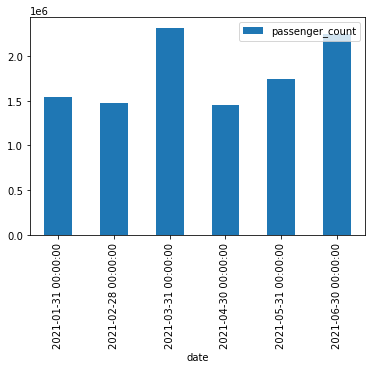

In [98]:
flightsDF['2021-01-01':].plot(kind='bar')

Timestamp objects can also deal with arithmetic

In [99]:
flightsDF.index[-1] - flightsDF.index[0]

Timedelta('1187 days 00:00:00')

<AxesSubplot:xlabel='date'>

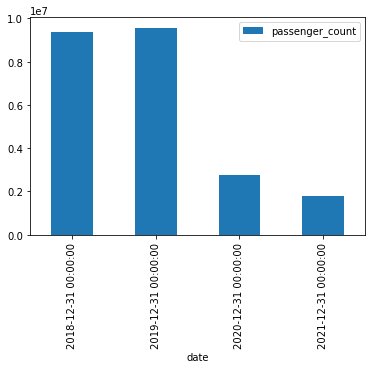

In [100]:
flightsDF.resample('Y').mean().plot(kind='bar')

## Grouping, Joining, Concatenating

You can get pretty far by jamming everything into a single dataframe, but sometimes you might want to do aggregate operations within a dataframe (e.g. group together all of the rows by year and show the mean value of some other column). Alternatively you might want to add new rows to or columns to an existing DataFrame or join dataframes based on shared key.


In [101]:
carsDF = pd.read_csv(
    'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv'
)
carsDF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


### Groupby
Let's group things by number_of_cylinders and see how that affects mpg...

In [102]:
carsDF['mpg'].mean()

23.514572864321615

Calling groupby on it's own will give you a `DataFrameGroupBy` object, you have to tell it what you want to do with the groups to actually see some results, this can be convenient if you want to look at different aggregate functions on the same groups.

In [103]:
carsDFbyCylinders = carsDF.groupby('cylinders')
carsDFbyCylinders

The typical aggregate operations are things like

  * mean()
  * sum()
  * median()
  * min()/max()

In [104]:
carsDFbyCylinders.mean()

,mpg,displacement,horsepower,weight,acceleration,model_year
cylinders,,,,,,
3,20.550000,72.500000,99.250000,2398.500000,13.250000,75.500000
4,29.286765,109.796569,78.281407,2308.127451,16.601471,77.073529
5,27.366667,145.000000,82.333333,3103.333333,18.633333,79.000000
6,19.985714,218.142857,101.506024,3198.226190,16.263095,75.928571
8,14.963107,345.009709,158.300971,4114.718447,12.955340,73.902913


Group the carsDF by model_year and look at the median mpg (don't include the other columns)

In [105]:
carsDF.groupby('model_year')['mpg'].median()

model_year
70    16.00
71    19.00
72    18.50
73    16.00
74    24.00
75    19.50
76    21.00
77    21.75
78    20.70
79    23.90
80    32.70
81    31.60
82    32.00
Name: mpg, dtype: float64

You can actually do much more with groupby, you can iterate over the groups

In [106]:
for vroom, group in carsDFbyCylinders:
    print(f"There are {group.shape[0]} cars with {vroom} cylinders")

There are 4 cars with 3 cylinders
There are 204 cars with 4 cylinders
There are 3 cars with 5 cylinders
There are 84 cars with 6 cylinders
There are 103 cars with 8 cylinders


How are there possibly 4 cars with 3 cylinders?!

We can apply multiple operations at the same time. The `.aggregate()` method can take a list of the operations you want to perform (e.g. ["max", "min"])

In [107]:
carsDFbyCylinders['mpg'].aggregate(["min","max"])

,min,max
cylinders,,
3,18.0,23.7
4,18.0,46.6
5,20.3,36.4
6,15.0,38.0
8,9.0,26.6


We can filter based on group, this is a silly example, but group the cars by cylinder, then show me all of the groups with a mean mpg > 15.

In [108]:
carsDFbyCylinders.filter(lambda x: x['mpg'].mean()>15).head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
14,24.0,4,113.0,95.0,2372,15.0,70,japan,toyota corona mark ii
15,22.0,6,198.0,95.0,2833,15.5,70,usa,plymouth duster
16,18.0,6,199.0,97.0,2774,15.5,70,usa,amc hornet
17,21.0,6,200.0,85.0,2587,16.0,70,usa,ford maverick
18,27.0,4,97.0,88.0,2130,14.5,70,japan,datsun pl510


The transform method lets you perform a group operation then use the results to update the rows. For example, we could calculate mean values for our groups, then look at how individual cars perform relative to that

In [109]:
carsDFbyCylinders.transform(lambda x: x - x.mean()).head()

<ipython-input-109-944b0487b527>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  carsDFbyCylinders.transform(lambda x: x - x.mean()).head()


,mpg,displacement,horsepower,weight,acceleration,model_year
0,3.036893,-38.009709,-28.300971,-610.718447,-0.95534,-3.902913
1,0.036893,4.990291,6.699029,-421.718447,-1.45534,-3.902913
2,3.036893,-27.009709,-8.300971,-678.718447,-1.95534,-3.902913
3,1.036893,-41.009709,-8.300971,-681.718447,-0.95534,-3.902913
4,2.036893,-43.009709,-18.300971,-665.718447,-2.45534,-3.902913


There is also an apply method which is even more general and will let you apply an arbitrary function to the group results.

## Concatenate & Join

There are a handful of functions which handle concatenation. The main workhorse is `pd.concat`, but there are some convenience functions which will let you avoid passing lots of arguments to concat. You can combine either `Series` and `DataFrames` but we'll jump straight to `DataFrames`,

In [110]:
s1 = pd.DataFrame(
    {
        'upper': ['A', 'B', 'C'], 
        'lower': ['a', 'b', 'c']
    }, 
    columns=['upper', 'lower'], 
    index=[1,2,3]
)

s2 = pd.DataFrame(
    {
        'upper': ['D', 'E', 'F'],
        'lower': ['d', 'e', 'f']
    }, 
    columns=['upper', 'lower'],
    index=[4,5,6]
)

pd.concat([s1,s2])

,upper,lower
1,A,a
2,B,b
3,C,c
4,D,d
5,E,e
6,F,f


Notice that we enclosed the thigs we want to join as some sort of iterable (a `list` here).

What if we wanted to add columns rather than rows

In [111]:
t1 = pd.DataFrame({'upper': ['A', 'B', 'C'], 'lower': ['a', 'b', 'c']}, columns=['upper', 'lower'], index=[1,2,3])
t2 = pd.DataFrame({'greek': ['α', 'β', 'γ']}, index=[1,2,3])

pd.concat([t1, t2], axis='columns')

,upper,lower,greek
1,A,a,α
2,B,b,β
3,C,c,γ


`pd.concat` will accept duplicate indices, but normally that indicates a problem with the data normalization. `concat` has a `verify_index` argument which can check for these problems and you can specify what you want to do with duplicates manually.

concat will often result in `NaN`s because some columns might not exist in both/all frames.

In [112]:
d4 = pd.DataFrame({'fruit': ['apple', 'orange'], 'veg': ['brocolli', 'carrot'], 'tree': ['cedar', 'alder']})
d5 = pd.DataFrame({'veg': ['onion', 'potato'], 'fruit': ['banana','grape']})
pd.concat([d4,d5], sort=False, ignore_index=True)

,fruit,veg,tree
0,apple,brocolli,cedar
1,orange,carrot,alder
2,banana,onion,NaN
3,grape,potato,NaN


Since the index wasn't important here, I threw it away and just accepted a new one.

In the general case, joining DataFrames can get complex. The concat method can take a `join` keyword to specify a database like join stragegy (inner or outer), but `pd.merge` is a bit more flexible. It implements the usual relations

  * one-to-one (similar to a concat)
  * many-to-one
  * many-to-many
  
For the many-to-one case here is an example

In [113]:
adf1=pd.DataFrame({
    'class': ['insect', 'spider'], 
    'legs': [6, 8]}
)

adf2=pd.DataFrame({
    'name': ['molly', 'anna', 'stephen', 'mica'], 
    'class': ['insect','insect','spider','insect']}
)                     

print(adf1); print(adf2)

    class  legs
0  insect     6
1  spider     8
      name   class
0    molly  insect
1     anna  insect
2  stephen  spider
3     mica  insect


In [114]:
pd.merge(adf1, adf2)

,class,legs,name
0,insect,6,molly
1,insect,6,anna
2,insect,6,mica
3,spider,8,stephen


The _many-to-one_ is many different rows in adf2 being mapped to a single row in adf1 (insects). `pd.merge` also accepts a selection of keyword arguments so you can manually specify which columns to join, patch up name differences etc.